In [3]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time
from IPython import display

# import functions from other python files
from fun1d import *
from optim import *

In [4]:
def gaussian(x, sigma):
    pi = math.pi
    y = 1 / np.sqrt(2 * pi) * np.exp(- x**2 / 2)
    return y

def window_filter_1d(n, s, xi, sigma):
    # generate one 1D gabor wavelet 
    x = np.arange(n) - np.floor(n/2)
    chi = np.zeros(n)
    chi = gaussian(x/s, sigma)
    
    o = np.exp(1j * xi * x)
    
    psi = np.multiply(chi, o)
    
    psi_hat = np.fft.fft(np.fft.fftshift(psi))
    return psi, psi_hat

def window_filter_family_1d(n, s, xi, sigma):
    # generate a family of 1D gabor wavelets with specified scales and rotations in space
    ns = s.shape[0]
    nxi = xi.shape[0]
    
    psi = np.zeros((n, ns, nxi),dtype=complex)
    psi_hat = np.zeros((n, ns, nxi),dtype=complex)
    for i in range(ns):
        for k in range(nxi):
                psi[:, i, k], psi_hat[:, i, k] = window_filter_1d(n, int(s[i]), xi[k], sigma)
    return psi, psi_hat

def determine_sigma(epsilon):
    sigma = np.sqrt(- 2 * np.log(epsilon)) / math.pi
    return sigma

def determine_J(N, Q, sigma, *alpha):
    if len(alpha) == 0:
        alpha = 3
    J = np.log2(N) - np.log2(alpha) - np.log2(sigma) - 1
    int_J = max(np.floor(J), 1);
    frac_J = (1/Q) * np.around((J - int_J) * Q);
    J = int_J + frac_J;
    return J

In [5]:
class parameter:
    def __init__(self, niter, nepoch, nbatch, optim, eta, beta, gamma, epsilon):
        self.niter = niter
        self.nepoch = nepoch
        self.nbatch = nbatch
        self.optim = optim # optimization option
        self.eta = eta
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon

In [6]:
def syn_SGD(x, psi_hat, psi, param, *args):
    # collect parameters
    nx = x.shape
    nw = psi_hat.shape[1]  # number of wavelets 
    max_epoch = param.nepoch
    optim = param.optim
    
    # scattering coefficients of original signal
    sx = np.sum(np.abs(wave_trans_in_freq_1d(x, psi_hat)),axis = 0)

    # initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random(nx[0]) 
    else:
        y0 = args[0]
        
    res = np.zeros((nx[0], max_epoch))
    for i in range(max_epoch):
        print('epoch: ', i)
        if optim == 'sgd':
            res[:, i] = sgd(y0, sx, psi_hat, psi, param)
        elif optim == 'sgd_with_mom':
            res[:, i] = sgd_with_mom(y0, sx, psi_hat, psi, param)
        elif optim == 'nag':
            res[:, i] = nag(y0, sx, psi_hat, psi, param)
        elif optim == 'rmsprop':
            res[:, i] = rmsprop(y0, sx, psi_hat, psi, param)
        elif optim == 'adam':
            res[:, i] = adam(y0, sx, psi_hat, psi, param)
        else:
            print('No such optimization algorithm.')
            break
        y0 = res[:, i]
        sy = np.sum(np.abs(wave_trans_in_freq_1d(y0, psi_hat)),axis = 0)
        print('current error: ', np.sum((sx - sy)**2))
    return res

def jacfun(y0, sx, psi_hat, psi):
    # jacobian function for difference
    epsilon = 1e-6
    n = y0.shape[0]
    nw = psi_hat.shape[1]
    
    temp1 = wave_trans_in_freq_1d(y0, psi_hat)
    temp3 = np.zeros(n)
    
    psi_shift = np.zeros((n,n), dtype = complex)
    
    sy = np.sum(np.abs(temp1), axis = 0)
    
    for i in range(nw):
        temp2 = temp1[:,i]
        for p in range(n):
            psi_shift[:, p] = np.roll(psi[:, i], p, axis = 0)
        temp = np.matmul(np.divide(np.real(temp2), abs(temp2) + epsilon), np.real(psi_shift)) + \
               np.matmul(np.divide(np.imag(temp2), abs(temp2) + epsilon), np.imag(psi_shift))
        temp3 = temp3 + 2 * (sy[i] - sx[i]) * temp
    return temp3

In [7]:
# set parameters
n = 2**11
pi = math.pi
l = 0.01

max_err = 1e-7
max_epoch = 3
jacob = True
z = False

niter = 50
nbatch = 5
nepoch = 10
eta = 1e-3
beta = 0.99
gamma = 0.9
epsilon = 1e-8
optim = 'adam'



param = parameter(niter = niter, 
                  nepoch = nepoch, 
                  nbatch = nbatch, 
                  optim = optim, 
                  eta = eta, 
                  beta = beta, 
                  gamma = gamma, 
                  epsilon = epsilon)
# sample signal
t = np.linspace(0, n + 1, n + 1)
y = sample_poisson(t, l)[0]
dy = np.diff(y)

# set up scales s and frequencies xi
sigma = determine_sigma(epsilon)
Q = 0.5
J = determine_J(n, Q, sigma, 2)
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J/Q)+1)))
xi = 2 * pi * np.random.choice(n,1) / n

# build wavelets
g, g_hat = window_filter_family_1d(n, s, xi, sigma)
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))


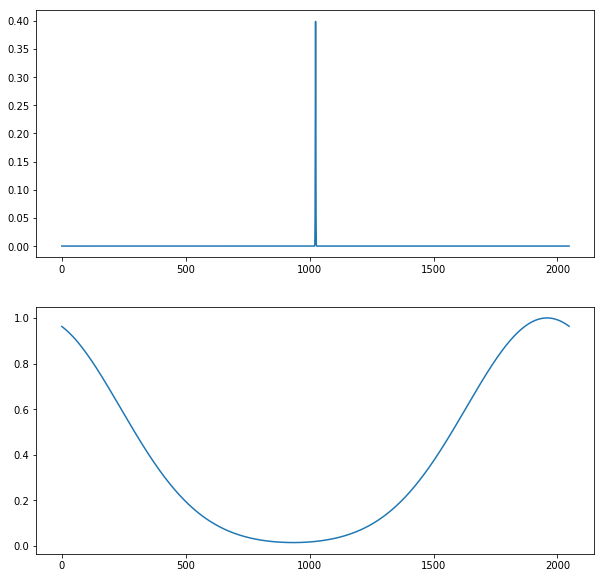

In [12]:
plt.figure(figsize = (10,10))
ind = 0
plt.subplot(2,1,1)
plt.plot(np.real(g[:,ind]))
plt.subplot(2,1,2)
plt.plot(np.real(g_hat[:,ind]))

In [5]:
# use SGD to synthesis
# res = syn_SGD(dy, g_hat, g, param)
# use greedy algorithm
res = synthesis(dy, g_hat, g, jacob, max_err, max_epoch, z)

epoch: 1


KeyboardInterrupt: 

In [2]:
# compute f
nsample = 5000
f = prod_f(g_hat, t, nsample, l)
n = 2**11
t = np.linspace(0, n + 1, n + 1)
y = sample_poisson(t, l)[0]
dy = np.diff(y)
f1 = np.mean(np.abs(wave_trans_in_freq_1d(dy, g_hat)), axis = 0)

NameError: name 'prod_f' is not defined

Text(0.5,0,'s')

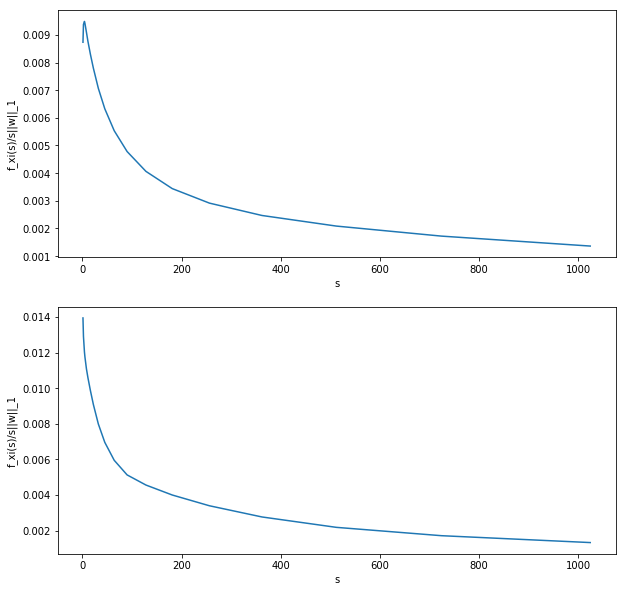

In [43]:
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(s, np.divide(f,s)) # ||w||_1 = 1 for standard gaussian
plt.ylabel('f_xi(s)/s||w||_1')
plt.xlabel('s')
plt.subplot(2,1,2)
plt.plot(s, np.divide(f1,s)) # ||w||_1 = 1 for standard gaussian
plt.ylabel('f_xi(s)/s||w||_1')
plt.xlabel('s')

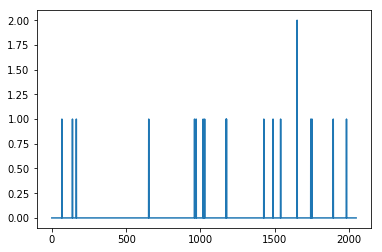

In [41]:
plt.plot(dy)

In [12]:
left = np.exp(-l * s) * l
right = np.multiply(np.exp(-l * s) * l, (1 + l * s))
# print(left)
print(np.divide(f1,s) - left)


[ 8.41684176e-04  9.02285041e-04  6.71574069e-04  5.49676976e-04
  2.93118535e-04  7.70048038e-05 -2.44644323e-04 -5.26394625e-04
 -7.14289402e-04 -5.82168987e-04 -2.36304301e-04  1.81739872e-04
  7.69224420e-04  1.20574926e-03  1.45191702e-03  1.51284262e-03
  1.33803300e-03]
